# **BidlySMU Prediction Example using V4**

<h2><span style="color:red">NOTE: use at your own discretion.</span></h2>

### **Objective**
This notebook demonstrates how to predict SMU course bidding outcomes using the **V4 three-model architecture**:
1. **Classification Model**: Predicts whether a course will receive bids (probability)
2. **Median Bid Model**: Predicts the median winning bid with uncertainty
3. **Min Bid Model**: Predicts the minimum winning bid with uncertainty

The predictions include **uncertainty quantification** and **safety factor multipliers** to help you make informed bidding decisions.

---


## **1. Setup and Installation**

### **Clone the Repository**
```bash
git clone https://github.com/tanzhongyan/BidlySMU/
cd BidlySMU
```

### **Install Dependencies**
```bash
pip install -r requirements.txt
```

Required packages:
- pandas
- numpy
- catboost
- scipy
- python-dotenv

---

## **2. Preperation**
### **2a. Import Libraries and Load Models**

In [119]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, CatBoostClassifier
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Load the three production models
print("Loading V4 models...")

# Classification model
clf_model = CatBoostClassifier()
clf_model.load_model('script_output/models/classification/production_classification_model.cbm')

# Median bid regression model
median_model = CatBoostRegressor()
median_model.load_model('script_output/models/regression_median/production_regression_median_model.cbm')

# Min bid regression model
min_model = CatBoostRegressor()
min_model.load_model('script_output/models/regression_min/production_regression_min_model.cbm')

print("✅ All models loaded successfully!")

Loading V4 models...
✅ All models loaded successfully!


### **2b. Load Safety Factor Table**

The safety factor table contains **uncertainty multipliers** for different confidence levels (beats percentages).

In [120]:
# Load safety factor table
safety_factor_df = pd.read_csv('safety_factor_table.csv')

# Display available beats percentages
print("Available confidence levels (beats percentages):")
unique_percentages = sorted(safety_factor_df['beats_percentage'].unique())
print(f"From {unique_percentages[0]}% to {unique_percentages[-1]}%")

# Function to get multiplier for a given beats percentage
def get_multiplier(prediction_type, beats_percentage, multiplier_type='empirical'):
    """
    Get the uncertainty multiplier for a given configuration
    
    Parameters:
    - prediction_type: 'median' or 'min'
    - beats_percentage: 1-99 (confidence level)
    - multiplier_type: 'empirical' or 'theoretical'
    """
    result = safety_factor_df[
        (safety_factor_df['prediction_type'] == prediction_type) & 
        (safety_factor_df['beats_percentage'] == beats_percentage) &
        (safety_factor_df['multiplier_type'] == multiplier_type)
    ]
    
    if not result.empty:
        return result['multiplier'].iloc[0]
    else:
        # Linear interpolation if exact percentage not found
        closest = safety_factor_df[
            (safety_factor_df['prediction_type'] == prediction_type) &
            (safety_factor_df['multiplier_type'] == multiplier_type)
        ].copy()
        closest['diff'] = abs(closest['beats_percentage'] - beats_percentage)
        return closest.nsmallest(1, 'diff')['multiplier'].iloc[0]


Available confidence levels (beats percentages):
From 1% to 99%


### **2c. Professor Name Mapping**

**IMPORTANT**: The model requires professor names in **afterclass format** (title case with CAPITALIZED surname). However, you can input names in **BOSS format** (all caps) which is easier to find.


In [121]:
# Load professor lookup table
professor_lookup_path = Path("professor_lookup.csv")
professor_lookup = {}

if professor_lookup_path.exists():
    professor_lookup_df = pd.read_csv(professor_lookup_path)
    
    # Create mapping dictionary from BOSS (all caps) to afterclass format
    for _, row in professor_lookup_df.iterrows():
        if pd.notna(row['boss_name']) and pd.notna(row['afterclass_name']):
            professor_lookup[str(row['boss_name']).strip().upper()] = str(row['afterclass_name']).strip()
    
    print(f"✅ Loaded {len(professor_lookup)} professor mappings")
else:
    print("⚠️ Professor lookup file not found.")

def process_instructors(instructor_input):
    """
    Process instructor names with sophisticated matching logic.
    Handles complex multi-instructor cases and ensures proper formatting.
    
    Returns: List of unique instructor names in afterclass format, sorted alphabetically
    """
    if pd.isna(instructor_input) or str(instructor_input).upper() == 'TBA':
        return []
    
    # Convert to string if needed
    if isinstance(instructor_input, list):
        instructor_str = ', '.join([str(inst).strip() for inst in instructor_input if pd.notna(inst)])
    else:
        instructor_str = str(instructor_input).strip()
    
    if not instructor_str:
        return []
    
    # Step 1: Check if entire string is a single professor
    if instructor_str.upper() in professor_lookup:
        return [professor_lookup[instructor_str.upper()]]
    
    # Step 2: Check hardcoded multi-instructor combinations
    multi_instructor_combinations = {
        "ERIC YEE SHIN CHONG, MANDY THAM": ["ERIC YEE SHIN CHONG", "MANDY THAM"],
        "ZHENG ZHICHAO, DANIEL, TAN KAR WAY": ["ZHENG ZHICHAO, DANIEL", "TAN KAR WAY"],
        "KAM WAI WARREN BARTHOLOMEW CHIK, LANX GOH": ["KAM WAI WARREN BARTHOLOMEW CHIK", "LANX GOH"],
        "ANDREW MIN HAN CHIN, DANIEL TAN": ["ANDREW MIN HAN CHIN", "DANIEL TAN"],
        "PAUL GRIFFIN, TA NGUYEN BINH DUONG": ["PAUL GRIFFIN", "TA NGUYEN BINH DUONG"],
        "ANDREW MIN HAN CHIN, JUNJI SUMITANI": ["ANDREW MIN HAN CHIN", "JUNJI SUMITANI"],
        "DAVID GOMULYA, LIM CHON PHUNG, AJAY MAKHIJA": ["DAVID GOMULYA", "LIM CHON PHUNG", "AJAY MAKHIJA"],
        "JACK HONG JIAJUN, ANG SER KENG": ["JACK HONG JIAJUN", "ANG SER KENG"],
        "DAVID GOMULYA, DAVID LLEWELYN": ["DAVID GOMULYA", "DAVID LLEWELYN"],
        "TERENCE FAN PING-CHING, JONATHAN TEE": ["TERENCE FAN PING-CHING", "JONATHAN TEE"],
        "RONG WANG, CHENG QIANG, CHEN XIA, LIANDONG ZHANG, WANG JIWEI, YUE HENG": ["RONG WANG", "CHENG QIANG", "CHEN XIA", "LIANDONG ZHANG", "WANG JIWEI", "YUE HENG"],
        "PASCALE CRAMA, ARNOUD DE MEYER": ["PASCALE CRAMA", "ARNOUD DE MEYER"],
        "TERENCE FAN PING-CHING, WILSON TENG": ["TERENCE FAN PING-CHING", "WILSON TENG"],
        "ANDREW MIN HAN CHIN, LI JIN": ["ANDREW MIN HAN CHIN", "LI JIN"],
        "ONG, BENJAMIN JOSHUA, EUGENE TAN KHENG BOON": ["ONG, BENJAMIN JOSHUA", "EUGENE TAN KHENG BOON"],
        "MANDY THAM, ERIC YEE SHIN CHONG": ["MANDY THAM", "ERIC YEE SHIN CHONG"],
        "TERENCE FAN PING-CHING, RUTH CHIANG": ["TERENCE FAN PING-CHING", "RUTH CHIANG"],
        "JARED POON JUN KEAT, CHAM YANWEI, DERRICK": ["JARED POON JUN KEAT", "CHAM YANWEI, DERRICK"],
        "DAVID GOMULYA, SZE TIAM LIN": ["DAVID GOMULYA", "SZE TIAM LIN"],
        "ANDREW MIN HAN CHIN, JAY WONG": ["ANDREW MIN HAN CHIN", "JAY WONG"],
        "MARK CHONG YIEW KIM, VICTOR OCAMPO": ["MARK CHONG YIEW KIM", "VICTOR OCAMPO"],
        "TSE, JUSTIN K, AIDAN WONG": ["TSE, JUSTIN K", "AIDAN WONG"],
        "TANG HONG WEE, GERALD SEAH, MUHAMMED AMEER S/O MOHAMED NOOR, LAU MENG YAN": ["TANG HONG WEE", "GERALD SEAH", "MUHAMMED AMEER S/O MOHAMED NOOR", "LAU MENG YAN"],
        "AURELIO GURREA MARTINEZ, LOH SONG-EN, SAMUEL": ["AURELIO GURREA MARTINEZ", "LOH SONG-EN, SAMUEL"],
        "CHNG SHUQI, AMELIA CHUA, MUHAMMED AMEER S/O MOHAMED NOOR": ["CHNG SHUQI", "AMELIA CHUA", "MUHAMMED AMEER S/O MOHAMED NOOR"]
    }
    
    if instructor_str.upper() in multi_instructor_combinations:
        split_names = multi_instructor_combinations[instructor_str.upper()]
    else:
        # Step 3: Progressive comma-based splitting with exact matching
        comma_parts = [part.strip() for part in instructor_str.split(',') if part.strip()]
        
        if len(comma_parts) <= 1:
            # Single professor
            if instructor_str.upper() in professor_lookup:
                return [professor_lookup[instructor_str.upper()]]
            else:
                # Check if it has at least 2 words
                words = instructor_str.strip().split()
                if len(words) >= 2:
                    return [instructor_str.strip()]
                else:
                    return []
        
        # Get all boss names for matching
        boss_names = set(professor_lookup.keys())
        
        professors_found = []
        i = 0
        
        while i < len(comma_parts):
            matched = False
            
            # Try progressive matching: add more comma parts until we find a match
            for j in range(i + 1, len(comma_parts) + 1):
                candidate = ', '.join(comma_parts[i:j])
                candidate_upper = candidate.upper()
                
                # Check for exact match
                if candidate_upper in boss_names:
                    professors_found.append(candidate)
                    i = j  # Move past all used parts
                    matched = True
                    break
                
                # Check for partial word match
                candidate_words = set(candidate.replace(',', ' ').split())
                for boss_name in boss_names:
                    boss_words = set(boss_name.replace(',', ' ').split())
                    if candidate_words.issubset(boss_words) and len(candidate_words) >= 2:
                        professors_found.append(candidate)
                        i = j
                        matched = True
                        break
                
                if matched:
                    break
            
            # If no match found, check if it's reasonable
            if not matched:
                single_part = comma_parts[i]
                words_in_part = single_part.split()
                
                if len(words_in_part) >= 2:
                    professors_found.append(single_part)
                    i += 1
                else:
                    # Try to combine with next part if available
                    if i + 1 < len(comma_parts):
                        combined = f"{single_part}, {comma_parts[i + 1]}"
                        professors_found.append(combined)
                        i += 2
                    else:
                        i += 1  # Skip single word professors
        
        # Filter to only keep professors with at least 2 words
        split_names = []
        for prof in professors_found:
            prof_words = prof.strip().replace(',', ' ').split()
            if len(prof_words) >= 2:
                split_names.append(prof)
        
        # If we couldn't split intelligently, treat as single professor
        if not split_names:
            prof_words = instructor_str.strip().replace(',', ' ').split()
            if len(prof_words) >= 2:
                split_names = [instructor_str]
            else:
                return []
    
    # Map each split name to afterclass format
    mapped_names = []
    for name in split_names:
        name_upper = name.strip().upper()
        if name_upper in professor_lookup:
            mapped_names.append(professor_lookup[name_upper])
        else:
            # Keep original if has multiple words
            words = name.strip().split()
            if len(words) >= 2:
                mapped_names.append(name.strip())
    
    # Remove duplicates and sort alphabetically
    unique_names = list(set(mapped_names))
    unique_names.sort()
    
    return unique_names

# Test the function with complex examples
test_cases = [
    "ZHENG ZHICHAO, DANIEL, TAN KAR WAY",
    "DAVID GOMULYA, LIM CHON PHUNG, AJAY MAKHIJA", 
    "TERENCE FAN PING-CHING, RUTH CHIANG"
]

print("Testing complex professor name handling:")
for test in test_cases:
    result = process_instructors(test)
    print(f"\nInput: '{test}'")
    print(f"Output: {result}")

✅ Loaded 1260 professor mappings
Testing complex professor name handling:

Input: 'ZHENG ZHICHAO, DANIEL, TAN KAR WAY'
Output: ['TAN Kar Way', 'ZHENG Zhichao Daniel']

Input: 'DAVID GOMULYA, LIM CHON PHUNG, AJAY MAKHIJA'
Output: ['Ajay MAKHIJA', 'GOMULYA, David', 'LIM Chon Phung']

Input: 'TERENCE FAN PING-CHING, RUTH CHIANG'
Output: ['Ruth CHIANG', 'Terence FAN']


### **2d. Data Transformer**

Load the SMUBiddingTransformer for feature engineering:

In [122]:
# Import the transformer (simplified version)
class SMUBiddingTransformer:
    """Transformer for SMU course bidding data - V4 compatible"""
    
    def __init__(self):
        self.is_fitted = False
        self.categorical_features = []
        self.numeric_features = []
    
    def fit(self, df):
        self.is_fitted = True
        return self
    
    def transform(self, df):
        if not self.is_fitted:
            raise ValueError("Transformer must be fitted first")
        
        df_transformed = df.copy()
        
        # Reset feature tracking
        self.categorical_features = []
        self.numeric_features = []
        
        # Extract features
        features = pd.DataFrame(index=df.index)
        
        # 1. Course features
        features['subject_area'] = df['course_code'].str.extract(r'([A-Z\-]+)')[0]
        features['catalogue_no'] = df['course_code'].str.extract(r'(\d+)')[0]
        self.categorical_features.extend(['subject_area', 'catalogue_no'])
        
        # 2. Round and window
        features['round'] = df['round']
        features['window'] = df['window']
        self.categorical_features.append('round')
        self.numeric_features.append('window')
        
        # 3. Basic features
        features['before_process_vacancy'] = df['before_process_vacancy']
        features['acad_year_start'] = df['acad_year_start']
        features['term'] = df['term'].astype(str)
        features['start_time'] = df['start_time'].astype(str)
        features['course_name'] = df['course_name'].astype(str)
        features['section'] = df['section'].astype(str)
        
        # Process instructor - ensure it's a unique, sorted list in JSON format
        features['instructor'] = df['instructor'].apply(
            lambda x: json.dumps(sorted(list(set(x)))) if isinstance(x, list) and x else json.dumps([])
        )
        
        self.numeric_features.extend(['before_process_vacancy', 'acad_year_start'])
        self.categorical_features.extend(['term', 'start_time', 'course_name', 'section', 'instructor'])
        
        # 4. Day features (one-hot encoding)
        day_columns = ['has_mon', 'has_tue', 'has_wed', 'has_thu', 'has_fri', 'has_sat', 'has_sun']
        for col in day_columns:
            features[col] = 0
        
        # Process day_of_week
        day_mapping = {
            'Mon': 'has_mon', 'Monday': 'has_mon',
            'Tue': 'has_tue', 'Tuesday': 'has_tue',
            'Wed': 'has_wed', 'Wednesday': 'has_wed',
            'Thu': 'has_thu', 'Thursday': 'has_thu',
            'Fri': 'has_fri', 'Friday': 'has_fri',
            'Sat': 'has_sat', 'Saturday': 'has_sat',
            'Sun': 'has_sun', 'Sunday': 'has_sun'
        }
        
        for idx, days in enumerate(df['day_of_week']):
            if isinstance(days, list):
                for day in days:
                    if day in day_mapping:
                        features.loc[df.index[idx], day_mapping[day]] = 1
            elif isinstance(days, str):
                for day in days.split(','):
                    day = day.strip()
                    if day in day_mapping:
                        features.loc[df.index[idx], day_mapping[day]] = 1
        
        self.numeric_features.extend(day_columns)
        
        # Handle missing values
        for col in self.categorical_features:
            if col in features.columns:
                features[col] = features[col].astype(str).replace('nan', '__NA__').fillna('__NA__')
        
        return features
    
    def fit_transform(self, df):
        return self.fit(df).transform(df)

# Initialize transformer
transformer = SMUBiddingTransformer()

### **2e. Calculate Uncertainties**

In [123]:
def calculate_uncertainty(model, X_data, n_iterations=10):
    """Calculate prediction uncertainty using virtual ensembles"""
    n_trees = model.tree_count_
    trees_per_subset = max(1, n_trees // n_iterations)
    
    subset_predictions = []
    for i in range(n_iterations):
        tree_start = i * trees_per_subset
        tree_end = min((i + 1) * trees_per_subset, n_trees)
        if tree_start < n_trees:
            partial_pred = model.predict(X_data, 
                                       ntree_start=tree_start, 
                                       ntree_end=tree_end)
            subset_predictions.append(partial_pred)
    
    return np.std(subset_predictions, axis=0)

# Calculate classification confidence
def calculate_confidence(probabilities):
    """Calculate entropy-based confidence score"""
    epsilon = 1e-10
    entropy = -np.sum(probabilities * np.log(probabilities + epsilon), axis=1)
    max_entropy = -np.log(1/probabilities.shape[1])
    confidence_score = 1 - (entropy / max_entropy)
    return confidence_score

### **2f. Interactive Prediction Results**

In [124]:
def display_prediction_results(idx, course_info, predictions, uncertainties, safety_factor_df):
    """Display prediction results in a user-friendly format"""
    
    print(f"\n{'='*60}")
    print(f"COURSE: {course_info['course_code']} - {course_info['course_name']}")
    print(f"Section: {course_info['section']} | Term: {course_info['term']}")
    print(f"Instructor(s): {', '.join(course_info['instructor'])}")
    print(f"Before Process Vacancy: {course_info['before_process_vacancy']}")
    print(f"{'='*60}")
    
    # Classification results
    has_bids_prob = clf_probabilities[idx, 1]
    confidence = clf_confidence[idx]
    
    print(f"\n🎯 BID LIKELIHOOD ANALYSIS")
    print(f"   Probability of receiving bids: {has_bids_prob:.2%}")
    print(f"   Model confidence: {confidence:.2%}")
    
    if has_bids_prob >= 0.5:
        print(f"   ✅ Classification: LIKELY to receive bids")
    else:
        print(f"   ⚠️  Classification: UNLIKELY to receive bids")
    
    # Regression predictions
    median_pred = median_predictions[idx]
    min_pred = min_predictions[idx]
    median_unc = uncertainties['median'][idx]
    min_unc = uncertainties['min'][idx]
    
    print(f"\n💰 BASE PREDICTIONS")
    print(f"   Median Bid: {median_pred:.2f} ± {median_unc:.2f}")
    print(f"   Min Bid: {min_pred:.2f} ± {min_unc:.2f}")
    
    # Interactive safety factor selection
    print(f"\n📊 RECOMMENDED BIDS BY CONFIDENCE LEVEL")
    print(f"   Formula: Recommended = Predicted + (Uncertainty × Multiplier)")
    print(f"\n   {'Level':<15} {'Median Bid':<15} {'Min Bid':<15}")
    print(f"   {'-'*45}")
    
    confidence_levels = [50, 60, 70, 80, 90, 95, 99]
    
    for level in confidence_levels:
        median_mult = get_multiplier('median', level)
        min_mult = get_multiplier('min', level)
        
        median_rec = median_pred + (median_unc * median_mult)
        min_rec = min_pred + (min_unc * min_mult)
        
        print(f"   {level}% confidence: {median_rec:>8.2f}      {min_rec:>8.2f}")
    
    # Strategy recommendation
    print(f"\n💡 BIDDING STRATEGY RECOMMENDATION")
    if confidence >= 0.7 and has_bids_prob >= 0.7:
        print("   🔴 HIGH COMPETITION - Bid aggressively!")
        print("   Recommended: Use 90-95% confidence level")
    elif confidence >= 0.7 and has_bids_prob < 0.3:
        print("   🟢 LOW COMPETITION - Conservative bid sufficient")
        print("   Recommended: Use 60-70% confidence level")
    else:
        print("   🟡 UNCERTAIN - Moderate approach advised")
        print("   Recommended: Use 80-85% confidence level")

### **2g. Custom Prediction Function**

In [125]:
def predict_course_bid(course_data, beats_percentage=90):
    """
    Predict bid amounts for a single course
    
    Parameters:
    -----------
    course_data : dict
        Dictionary containing course information
        - instructor: Can be string (BOSS format), list, or comma-separated
    beats_percentage : int
        Confidence level (1-99) for bid recommendation
    
    Returns:
    --------
    dict : Prediction results including probabilities, base predictions, and recommendations
    """
    
    # Process instructor names to afterclass format
    course_data['instructor'] = process_instructors(course_data.get('instructor', 'TBA'))
    
    # Ensure day_of_week is in array format
    if not isinstance(course_data.get('day_of_week'), list):
        if isinstance(course_data.get('day_of_week'), str):
            course_data['day_of_week'] = [d.strip() for d in course_data['day_of_week'].split(',')]
        else:
            course_data['day_of_week'] = []
    
    # Create DataFrame
    df = pd.DataFrame([course_data])
    
    # Transform features
    X = transformer.fit_transform(df)
    
    # Make predictions
    clf_prob = clf_model.predict_proba(X)[0]
    median_pred = median_model.predict(X)[0]
    min_pred = min_model.predict(X)[0]
    
    # Calculate uncertainties
    median_unc = calculate_uncertainty(median_model, X)[0]
    min_unc = calculate_uncertainty(min_model, X)[0]
    
    # Get multipliers
    median_mult = get_multiplier('median', beats_percentage)
    min_mult = get_multiplier('min', beats_percentage)
    
    # Calculate recommendations
    median_rec = median_pred + (median_unc * median_mult)
    min_rec = min_pred + (min_unc * min_mult)
    
    # Calculate confidence
    confidence = calculate_confidence(clf_prob.reshape(1, -1))[0]
    
    return {
        'clf_has_bids_prob': clf_prob[1],
        'clf_confidence_score': confidence,
        'median_predicted': median_pred,
        'median_uncertainty': median_unc,
        'median_recommended': median_rec,
        'min_predicted': min_pred,
        'min_uncertainty': min_unc,
        'min_recommended': min_rec,
        'beats_percentage': beats_percentage,
        'median_multiplier': median_mult,
        'min_multiplier': min_mult
    }

---

## **3. Run Prediction**

![How to extract data required for models.png](<attachment:How to extract data required for models.png>)

<span style="color:red;font-size: 1.5em">* NOTE: Copy the information exactly. Any deviation will lead to different prediction values.</span>

### **3a. Summary Prediction**
Run this cell to get predictions for multiple courses at once:
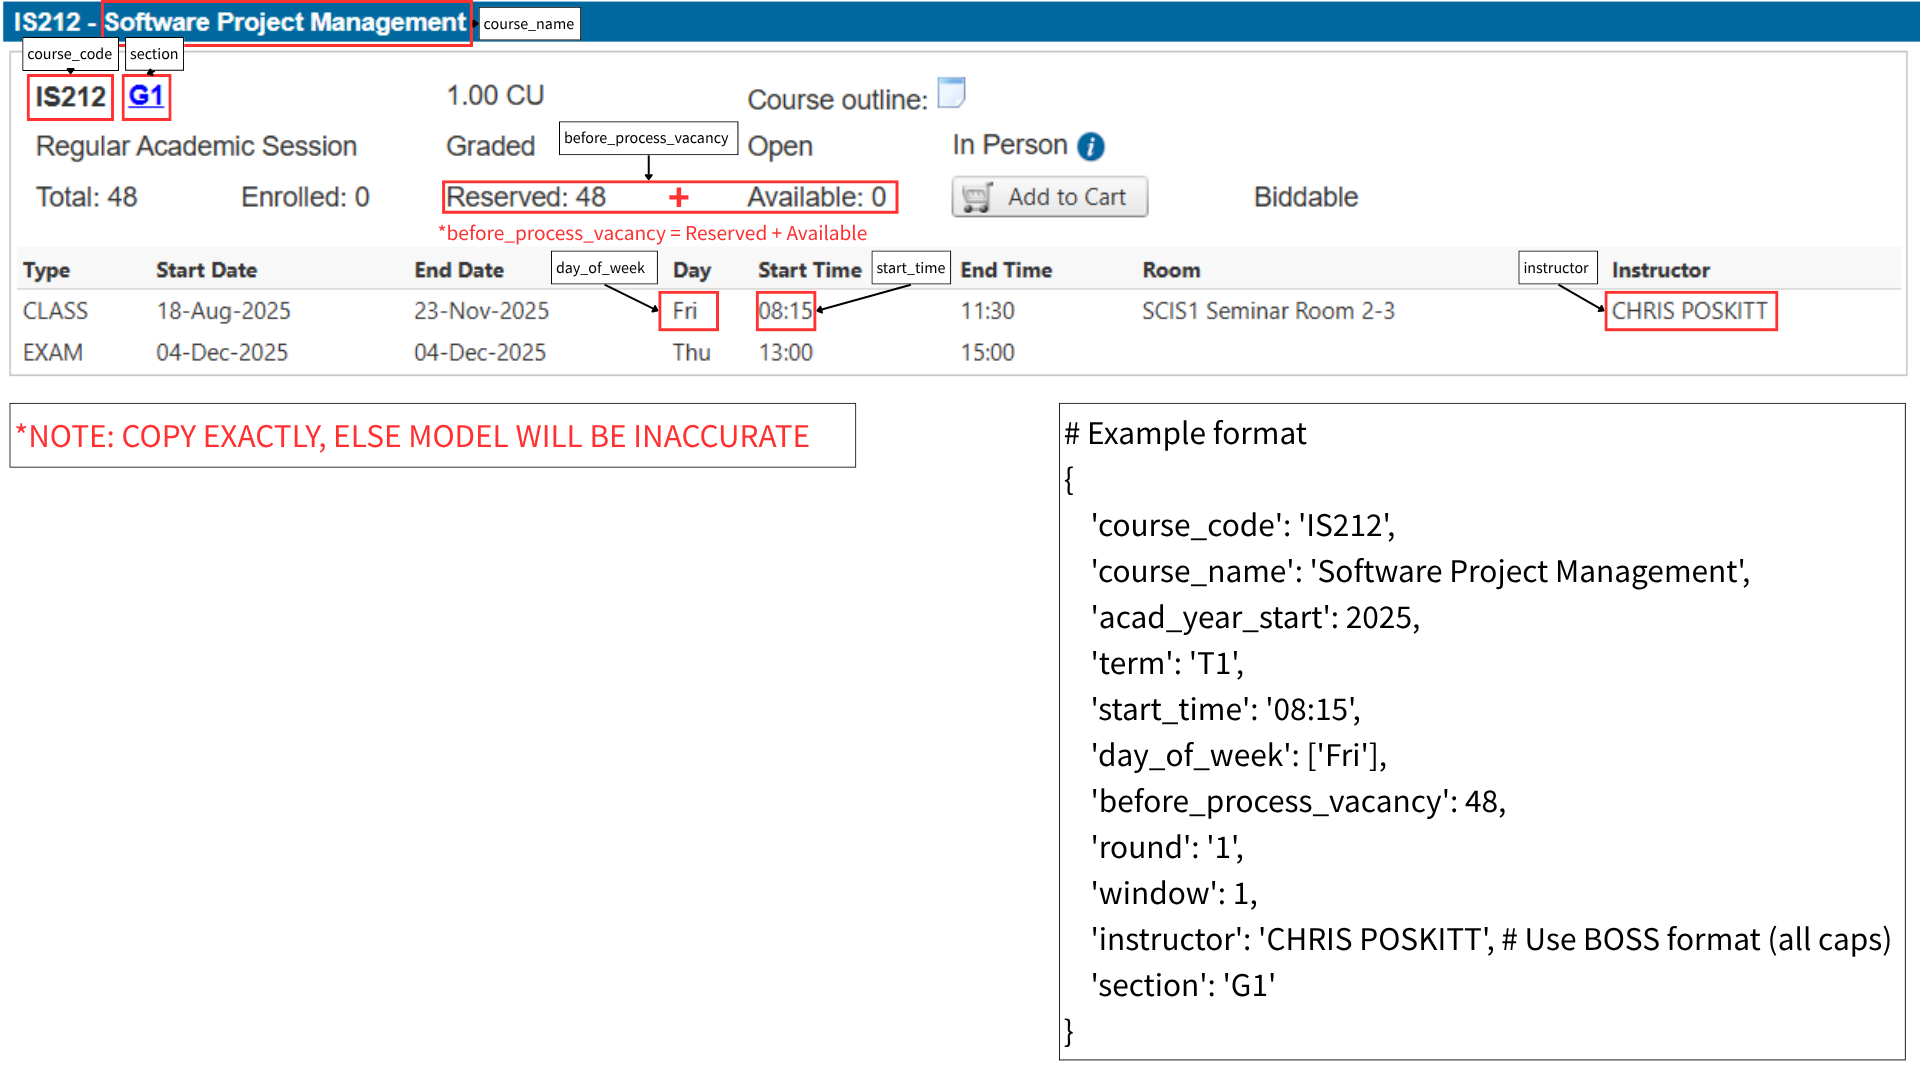

In [126]:
# Define your courses here - copy details from BOSS
courses_to_predict = [
    {
        'acad_year_start': 2025,
        'term': 'T1',
        'round': '1',
        'window': 1,
        'course_code': 'IS212',
        'course_name': 'Software Project Management',
        'section': 'G1',
        'before_process_vacancy': 48,
        'day_of_week': ['Fri'],
        'start_time': '08:15',
        'instructor': 'CHRIS POSKITT',  # Use BOSS format (all caps)
    },
    {
        'acad_year_start': 2025,
        'term': 'T1',
        'round': '1',
        'window': 1,
        'course_code': 'IS212',
        'course_name': 'Software Project Management',
        'section': 'G2',
        'before_process_vacancy': 48,
        'day_of_week': ['Fri'],
        'start_time': '12:00',
        'instructor': 'CHRIS POSKITT',  # Use BOSS format (all caps)
    }
]

# Convert to DataFrame and process
examples_df = pd.DataFrame(courses_to_predict)

# Process instructor names
for idx, row in examples_df.iterrows():
    examples_df.at[idx, 'instructor'] = process_instructors(row['instructor'])

# Transform and predict
X_transformed = transformer.fit_transform(examples_df)

# Make predictions
clf_probabilities = clf_model.predict_proba(X_transformed)
median_predictions = median_model.predict(X_transformed)
min_predictions = min_model.predict(X_transformed)

# Calculate uncertainties
median_uncertainty = calculate_uncertainty(median_model, X_transformed)
min_uncertainty = calculate_uncertainty(min_model, X_transformed)
clf_confidence = calculate_confidence(clf_probabilities)

# Display results for all courses
for idx, row in examples_df.iterrows():
    display_prediction_results(
        idx, 
        row.to_dict(),
        {'median': median_predictions, 'min': min_predictions},
        {'median': median_uncertainty, 'min': min_uncertainty},
        safety_factor_df
    )


COURSE: IS212 - Software Project Management
Section: G1 | Term: T1
Instructor(s): Chris POSKITT
Before Process Vacancy: 48

🎯 BID LIKELIHOOD ANALYSIS
   Probability of receiving bids: 99.99%
   Model confidence: 99.86%
   ✅ Classification: LIKELY to receive bids

💰 BASE PREDICTIONS
   Median Bid: 28.96 ± 7.62
   Min Bid: 25.65 ± 6.00

📊 RECOMMENDED BIDS BY CONFIDENCE LEVEL
   Formula: Recommended = Predicted + (Uncertainty × Multiplier)

   Level           Median Bid      Min Bid        
   ---------------------------------------------
   50% confidence:    28.88         25.79
   60% confidence:    30.94         27.23
   70% confidence:    33.15         28.64
   80% confidence:    36.12         30.84
   90% confidence:    41.03         34.84
   95% confidence:    46.26         39.17
   99% confidence:    57.44         48.66

💡 BIDDING STRATEGY RECOMMENDATION
   🔴 HIGH COMPETITION - Bid aggressively!
   Recommended: Use 90-95% confidence level

COURSE: IS212 - Software Project Manageme

### **3b. Custom Prediction - Define percetange to beat other bids**

In [127]:
# Your course details (copy directly from BOSS)
my_course = {
    'acad_year_start': 2025,
    'term': 'T1',
    'round': '1',
    'window': 1,
    'course_code': 'IS212',
    'course_name': 'Software Project Management',
    'section': 'G1',
    'before_process_vacancy': 48,
    'day_of_week': ['Fri'],
    'start_time': '08:15',
    'instructor': 'CHRIS POSKITT',  # Use BOSS format (all caps)
}

# Choose your confidence level (what % of other bids you want to beat)
confidence_level = 90  # 1-99% available. Increment in steps of 1% for more granularity.

# Get prediction
results = predict_course_bid(my_course, beats_percentage=confidence_level)

# Display results
print(f"\n🎯 PREDICTION RESULTS FOR {my_course['course_code']}:")
print(f"{'='*50}")
print(f"Bid Probability: {results['clf_has_bids_prob']:.2%}")
print(f"Model Confidence: {results['clf_confidence_score']:.2%}")

print(f"\n💰 BASE PREDICTIONS:")
print(f"  Median: {results['median_predicted']:.2f} ± {results['median_uncertainty']:.2f}")
print(f"  Min: {results['min_predicted']:.2f} ± {results['min_uncertainty']:.2f}")

print(f"\n📊 RECOMMENDED BIDS ({confidence_level}% confidence):")
print(f"  Median: {results['median_recommended']:.2f}")
print(f"  Min: {results['min_recommended']:.2f}")

# Quick decision helper
if results['clf_has_bids_prob'] > 0.7:
    if results['clf_confidence_score'] > 0.7:
        print(f"\n💡 STRATEGY: 🔴 HIGH COMPETITION - Bid aggressively!")
    else:
        print(f"\n💡 STRATEGY: 🟡 MODERATE COMPETITION - Be cautious")
else:
    print(f"\n💡 STRATEGY: 🟢 LOW COMPETITION - Conservative bid OK")

# Compare different confidence levels
print(f"\n📈 CONFIDENCE LEVEL COMPARISON:")
print(f"{'Level':<8} {'Median':<8} {'Min':<8}")
print(f"{'-'*24}")
for level in [70, 80, 90, 95, 99]:
    temp_results = predict_course_bid(my_course, beats_percentage=level)
    print(f"{level}%{'':<5} {temp_results['median_recommended']:<8.2f} {temp_results['min_recommended']:<8.2f}")


🎯 PREDICTION RESULTS FOR IS212:
Bid Probability: 99.99%
Model Confidence: 99.86%

💰 BASE PREDICTIONS:
  Median: 28.96 ± 7.62
  Min: 25.65 ± 6.00

📊 RECOMMENDED BIDS (90% confidence):
  Median: 41.03
  Min: 34.84

💡 STRATEGY: 🔴 HIGH COMPETITION - Bid aggressively!

📈 CONFIDENCE LEVEL COMPARISON:
Level    Median   Min     
------------------------
70%      33.15    28.64   
80%      36.12    30.84   
90%      41.03    34.84   
95%      46.26    39.17   
99%      57.44    48.66   


---

## **4. APPENDIX: Common Use Cases & Examples**

### **4a. Quick Single Course Prediction**

```python
# Minimal example - just fill in your course details
my_course = {
   'acad_year_start': 2025,
   'term': 'T1',  # 'T1', 'T2', 'T3A', 'T3B'
   'round': '1',  # '1', '1A', '1B', '1C', '2', '2A'
   'window': 1,
   'course_code': 'YOUR_COURSE',
   'course_name': 'Your Course Name',
   'section': 'G1',
   'before_process_vacancy': 30,
   'day_of_week': ['Mon', 'Wed'],
   'start_time': '19:00',
   'instructor': 'PROFESSOR NAME FROM BOSS',  # Use BOSS format (all caps)
}

results = predict_course_bid(my_course, beats_percentage=85)
print(f"Recommended bid: {results['median_recommended']:.2f}")
```

### **4b. Professor Name Formats**

The model accepts various instructor name formats:

```python
# Single professor
'instructor': 'TERENCE FAN PING-CHING'

# Multiple professors (comma-separated)
'instructor': 'DAVID GOMULYA, LIM CHON PHUNG'

# Multiple professors (as list)
'instructor': ['ANDREW MIN HAN CHIN', 'DANIEL TAN']

# Complex multi-instructor cases
'instructor': 'ZHENG ZHICHAO, DANIEL, TAN KAR WAY'

# TBA/Unknown instructor
'instructor': 'TBA'  # or leave empty
```

### **4c. Day of Week Formats**

```python
# As list (recommended)
'day_of_week': ['Mon', 'Wed', 'Fri']

# As comma-separated string
'day_of_week': 'Mon, Wed, Fri'

# Single day
'day_of_week': ['Tue']

# Full day names also work
'day_of_week': ['Monday', 'Wednesday']
```

### **4d. Confidence Level Guidelines**

```python
# Conservative (beat 70% of other bids)
results = predict_course_bid(my_course, beats_percentage=70)

# Moderate (beat 85% of other bids)
results = predict_course_bid(my_course, beats_percentage=85)

# Aggressive (beat 95% of other bids)
results = predict_course_bid(my_course, beats_percentage=95)

# Very aggressive (beat 99% of other bids)
results = predict_course_bid(my_course, beats_percentage=99)
```

### **4e. Batch Processing Multiple Courses**

```python
# Process multiple courses from a list
course_codes = ['IS214', 'MGMT317', 'FIN201']
instructors = ['RAFAEL J. BARROS', 'DAVID GOMULYA', 'JOHN DOE']

results_summary = []
for i, code in enumerate(course_codes):
   course = {
       'acad_year_start': 2025,
       'term': 'T1',
       'round': '1',
       'window': 1,
       'course_code': code,
       'course_name': f'Course {i+1}',
       'section': 'G1',
       'before_process_vacancy': 30,
       'day_of_week': ['Mon'],
       'start_time': '19:00',
       'instructor': instructors[i],
   }
   
   result = predict_course_bid(course, beats_percentage=85)
   results_summary.append({
       'course': code,
       'recommended_bid': result['median_recommended'],
       'competition_level': 'High' if result['clf_has_bids_prob'] > 0.7 else 'Low'
   })

# Display summary
for item in results_summary:
   print(f"{item['course']}: Bid {item['recommended_bid']:.0f} ({item['competition_level']} competition)")
```

### **4f. Understanding the Outputs**

```python
results = predict_course_bid(my_course, beats_percentage=85)

# Key metrics explanation:
print(f"Bid Probability: {results['clf_has_bids_prob']:.2%}")  # Chance course gets bids
print(f"Model Confidence: {results['clf_confidence_score']:.2%}")  # How sure the model is

print(f"Base Median: {results['median_predicted']:.2f}")  # Raw prediction
print(f"Uncertainty: ±{results['median_uncertainty']:.2f}")  # How much it could vary

print(f"Recommended: {results['median_recommended']:.2f}")  # Your bid amount
print(f"Safety Factor: {results['median_multiplier']:.2f}")  # Risk adjustment used
```

### **4g. Risk Management Strategies**

```python
# Conservative strategy (lower risk, lower success rate)
conservative = predict_course_bid(my_course, beats_percentage=70)

# Balanced strategy (moderate risk, good success rate)  
balanced = predict_course_bid(my_course, beats_percentage=85)

# Aggressive strategy (higher risk, higher success rate)
aggressive = predict_course_bid(my_course, beats_percentage=95)

print("Strategy Comparison:")
print(f"Conservative: {conservative['median_recommended']:.2f}")
print(f"Balanced:     {balanced['median_recommended']:.2f}")
print(f"Aggressive:   {aggressive['median_recommended']:.2f}")

# Choose based on:
# - How much you want the course
# - Your available bid points
# - Competition level indicated by model
```